<head>
    <link rel="stylesheet" href="CSS/notebook_theme.css" id="theme">
</head>
<img src="figures/logo.png" align="right" width="25%">
<h1 style="color:blue; text-align:center">BICePs v3.0</h1>


<h5 style="text-align:center;font-size: 18pt;font-weight:bold">Tutorial: Sampling iteratively for checking convergence in MCMC trajectories</h5>






In [1]:
import time, os
import biceps
import repXroutines as rxr
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


### Here, we will use a 5 state toy model system with 21 observables to demonstrate convergence checking.  We will start by sampling for 1k steps. We know that this is a very small number of steps that will most certainly be unconverged. 

In [2]:
total_nsteps = 0

####### Parameters #######
nStates,Nd = 5,21  # 2, 5, 10, 20  # 20, 50, 100, 200
n_lambdas,nreplicas,nsteps,change_Nr_every,swap_every=2,8,1000,0,0

#σ_prior, σ_data, μ_data = 0.161, 0.0, 0.0
σ_prior, σ_data, μ_data = 0.161, 0.5, 4.0

#stat_model, data_uncertainty = "SinglePrior", "single"
stat_model, data_uncertainty = "GB", "single"
#stat_model, data_uncertainty = "Gaussian", "multiple"

burn = 0
scale_energies = 0
find_optimal_nreplicas = 0
multiprocess=1
attempt_move_state_every = 1
attempt_move_sigma_every = 1
scale_and_offset = 0
move_ftilde_every = 0
dftilde = 1.10
ftilde_sigma = 1.0 
walk_in_all_dim=0
write_every = 2

plottype="step"
#plottype="hist"

#data_likelihood = "log normal" # "gaussian"
data_likelihood = "gaussian" #"log normal" # "gaussian"
verbose = True
if verbose:
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None

iterations = 8 # includes the first biceps run

Populations:           [0.38189812 0.33373404 0.13103234 0.11634037 0.03699513]
Perturbed Populations: [0.27778196 0.23556732 0.07575278 0.21247338 0.19842456]
Energies:              [0.96260141 1.09741089 2.0323111  2.15123518 3.29696896]
Perturbed Energies:    [1.28091878 1.44575854 2.58028016 1.54893858 1.61734631]
RMSE in populations:   0.11332900443830894
RMSE in energies:      0.8610267774075743

(μ_data, σ_data) = (4.0, 0.5)

Experimental errors: [0.65593449 5.62924107 0.24812843 1.01767489 0.18380623 0.07587686
 0.39152457 0.60070408 5.34234963 0.10731295 0.34405378 0.17530135
 3.49617179 0.17210807 3.56272524 0.72289321 0.12714655 3.33161221
 3.52257304 1.06859772 0.42064054]
N data points perturbed: 21
sigma: 2.0905959925565964
Input data: ['.noe']


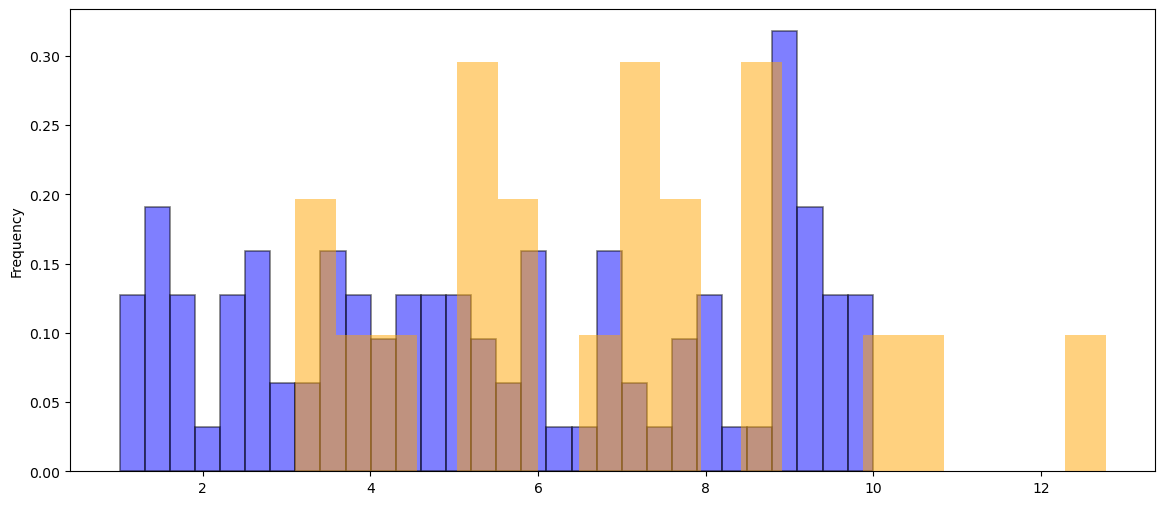

In [3]:
%matplotlib inline
state_dir = f"{nStates}_state"
biceps.toolbox.mkdir(state_dir)
dir = f"{state_dir}/{nStates}_state_{Nd}_datapoints/Prior_error_{σ_prior}"

boltzmann_scale=1.
boltzmann_domain=(0.12,0.6)
boltzmann_loc=0.0
rxr.gen_synthetic_data(dir, nStates, Nd, σ_prior=σ_prior, σ_data=σ_data, μ_data=μ_data,
        boltzmann_scale=boltzmann_scale, boltzmann_domain=boltzmann_domain, boltzmann_loc=boltzmann_loc, verbose=verbose)
plt.close()
populations = np.loadtxt(f"{dir}/pops.txt")
energies = np.loadtxt(f"{dir}/prior.txt")
energies -= energies.min()
################################################################################
data_dir = dir+"/NOE"
input_data = biceps.toolbox.sort_data(data_dir)
print(f"Input data: {biceps.toolbox.list_extensions(input_data)}")
model = pd.concat([pd.read_pickle(i) for i in biceps.toolbox.get_files(f"{data_dir}/*.noe")])
ax2 = model["model"].plot.hist(alpha=0.5, bins=30, edgecolor='black', linewidth=1.2, density=1, color="b", figsize=(14, 6), label="data1", ax=None)
model["exp"].plot.hist(bins=20, alpha=0.5, ax=ax2, color="orange", density=True)
fig2 = ax2.get_figure()
#fig2.savefig(f"{dir}/synthetic_experimental_NOEs.png")

In [4]:
outdir = f'{dir}/{stat_model}_{data_uncertainty}_sigma/{nsteps}_steps_{nreplicas}_replicas_{n_lambdas}_lam__swap_every_{swap_every}'
biceps.toolbox.mkdir(outdir)
temp_outdir = outdir+f"/iteration_{0}"
biceps.toolbox.mkdir(temp_outdir)
print(f"nSteps of sampling: {nsteps}\nnReplicas: {nreplicas}")
lambda_values = np.linspace(0.0, 1.0, n_lambdas)

sigMin, sigMax, dsig = 0.001, 200, 1.02
arr = np.exp(np.arange(np.log(sigMin), np.log(sigMax), np.log(dsig)))
l = len(arr)
sigma_index = round(l*0.73)#1689 # 0.80
parameters = [dict(ref="uniform", sigma=(sigMin, sigMax, dsig), gamma=(1.0, 2.0, np.e),
            data_uncertainty=data_uncertainty,
            data_likelihood=data_likelihood,
            stat_model=stat_model,
            sigma_index=sigma_index)]#, uncertainties="single"),]
print("len = ",l)
print("simga = ",arr[sigma_index])
pd.DataFrame(parameters)

nSteps of sampling: 1000
nReplicas: 8
len =  617
simga =  7.414421865415453


,ref,sigma,gamma,data_uncertainty,data_likelihood,stat_model,sigma_index
0,uniform,"(0.001, 200, 1.02)","(1.0, 2.0, 2.718281828459045)",single,gaussian,GB,450


In [5]:
dbName = "iterative_biceps.pkl"

converge_dir = f"{outdir}/convergence_results"
biceps.toolbox.mkdir(converge_dir)

In [6]:
ensemble = biceps.ExpandedEnsemble(lambda_values=lambda_values, energies=energies)
ensemble.initialize_restraints(input_data, parameters)
sampler = biceps.PosteriorSampler(ensemble, nreplicas, change_Nr_every,
        write_every=write_every,
        dftilde=dftilde, move_ftilde_every=move_ftilde_every,
        ftilde_sigma=ftilde_sigma, scale_and_offset=scale_and_offset)

In [7]:
sampler.sample(nsteps, attempt_lambda_swap_every=swap_every, swap_sigmas=0,
        find_optimal_nreplicas=find_optimal_nreplicas,
        attempt_move_state_every=attempt_move_state_every,
        attempt_move_sigma_every=attempt_move_sigma_every,
        burn=burn, print_freq=1, walk_in_all_dim=walk_in_all_dim,
        verbose=0, progress=1, multiprocess=multiprocess, capture_stdout=1)
total_nsteps += nsteps

 ██████████████████████████████▏ 100.0% [1000/1000 | 66.1 kHz | 1 | 0s | 0s] MCMC 


cannot convert float NaN to integer
<class 'ValueError'> convergence.py 393
cannot convert float NaN to integer
<class 'ValueError'> convergence.py 417


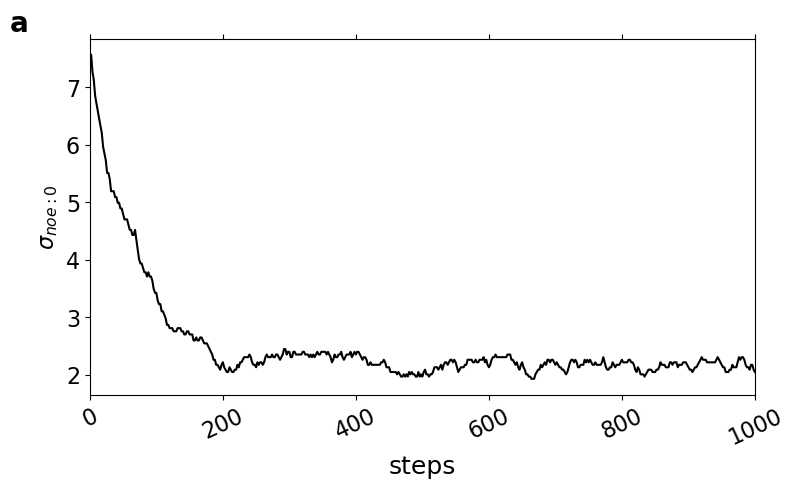

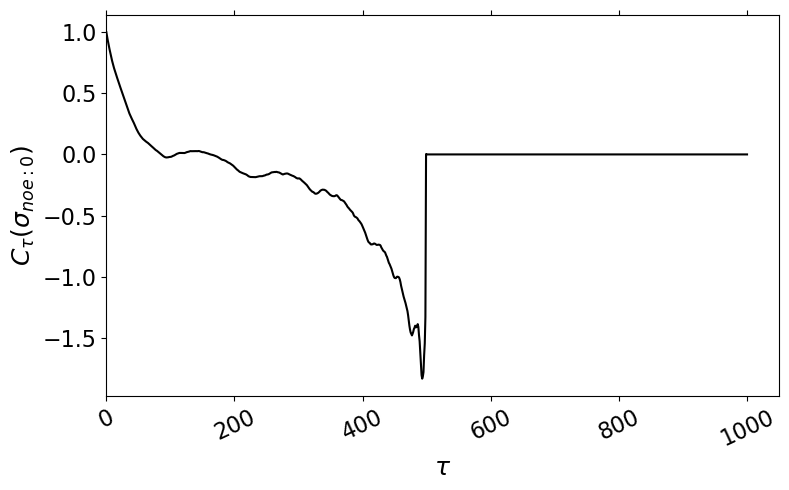

In [8]:
figsize=(8,5)
traj = sampler.traj[-1].__dict__
C = biceps.Convergence(traj, outdir=converge_dir)
C.plot_traces(figname="test.pdf", xlim=(0, traj["trajectory"][-1][0]), figsize=figsize)
#C.get_autocorrelation_curves(method="auto", nblocks=2, maxtau=2000, figsize=figsize)
C.get_autocorrelation_curves(method="block-avg-auto", nblocks=1, maxtau=1000, figsize=figsize)
#C.process()

### From the autocorrelation curve above, it is clear that convergence has not be reached. However, we still have the sampler object in memory. We should be able to continue sampling and pickup where we left off.

### Let's compute the current RMSE after 1k steps to show that our predicted populations will change as we continue sampling for longer...

In [9]:
# These are two other approaches for checking the populations. 

# 1. uses MBAR to compute expectations and extract uncertainties (better)
#pops = sampler.get_results()["pops"][:,n_lambdas-1]
#RMSE = np.sqrt(metrics.mean_squared_error(pops, populations))
#print(f"\n\nRMSE = {RMSE}")

# 2. uses counts of sampled states
#pops = sampler.populations[-1]
#print(pops)
#RMSE = np.sqrt(metrics.mean_squared_error(pops, populations))
#print(f"\n\nRMSE = {RMSE}")

# 3. MBAR
expanded_values = sampler.expanded_values
A = biceps.Analysis(sampler, outdir=outdir, MBAR=True)
A.plot_energy_trace()
BS, pops = A.f_df, A.P_dP[:,len(expanded_values[:])-1]
BS /= sampler.nreplicas
K = len(expanded_values[:])-1
pops_std = A.P_dP[:,2*K]
print(f"Predicted populatins: {pops}")
RMSE = np.sqrt(metrics.mean_squared_error(pops, populations))
print(f"\n\nRMSE = {RMSE}")

 ██████████████████████████████▏ 100.0% [ 500/ 500 | 310.2 kHz | 1 | 0s | 0s] u_kln 
Time for MBAR: 0.384 s
Writing 5_state/5_state_21_datapoints/Prior_error_0.161/GB_single_sigma/1000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing 5_state/5_state_21_datapoints/Prior_error_0.161/GB_single_sigma/1000_steps_8_replicas_2_lam__swap_every_0/populations.dat...
Predicted populatins: [0.3850149  0.26343994 0.00785281 0.30889644 0.03398351]


RMSE = 0.10696829743337832


### Now, let's sample for more 10k more steps, then 10k more steps... does the RMSE converge? How about the autocorrelation curves?

 ██████████████████████████████▏ 100.0% [10000/10000 | 98.8 kHz | 1 | 0s | 0s] MCMC 
 ██████████████████████████████▏ 100.0% [5499/5499 | 412.0 kHz | 1 | 0s | 0s] u_kln 


RMSE = 0.10761046853291793
total nsteps: 10998
 ██████████████████████████████▏ 100.0% [10000/10000 | 91.3 kHz | 1 | 0s | 0s] MCMC 
 ███████████████████████████▏  ▏ 90.5% [9500/10498 | 388.6 kHz | 1 | 0s | 0s] u_kln 


RMSE = 0.10685069205589671
total nsteps: 20996


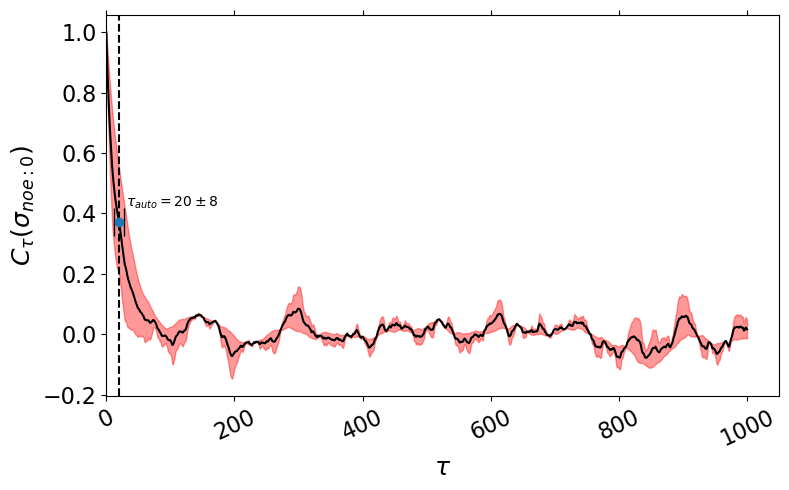

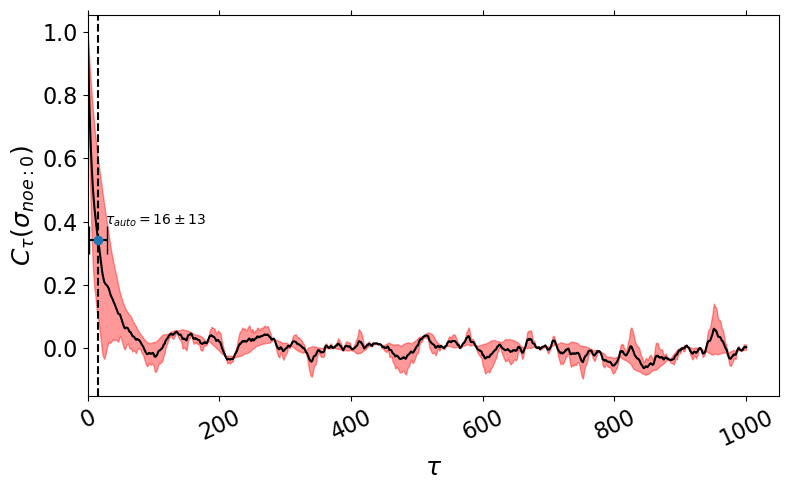

In [10]:
nsteps = 10000 # changing to 10k steps 
for i in range(2):
    total_nsteps += nsteps
    sampler.sample(nsteps, attempt_lambda_swap_every=swap_every, swap_sigmas=1,
            find_optimal_nreplicas=find_optimal_nreplicas,
            attempt_move_state_every=attempt_move_state_every,
            attempt_move_sigma_every=attempt_move_sigma_every,
            burn=burn, print_freq=1, walk_in_all_dim=walk_in_all_dim,
            verbose=0, progress=1, multiprocess=multiprocess, capture_stdout=1)
    pops = sampler.get_results()["pops"][:,n_lambdas-1]
    RMSE = np.sqrt(metrics.mean_squared_error(pops, populations))
    print(f"\n\nRMSE = {RMSE}")
    figsize=(8,5)
    traj = sampler.traj[-1].__dict__
    print(f"total nsteps: {traj['trajectory'][-1][0]}")
    C = biceps.Convergence(traj, outdir=converge_dir)
    #C.plot_traces(figname="test.pdf", xlim=(0, traj["trajectory"][-1][0]), figsize=figsize)

    #C.get_autocorrelation_curves(method="auto", nblocks=2, maxtau=2000, figsize=figsize)
    C.get_autocorrelation_curves(method="block-avg-auto", nblocks=2, maxtau=1000, figsize=figsize)

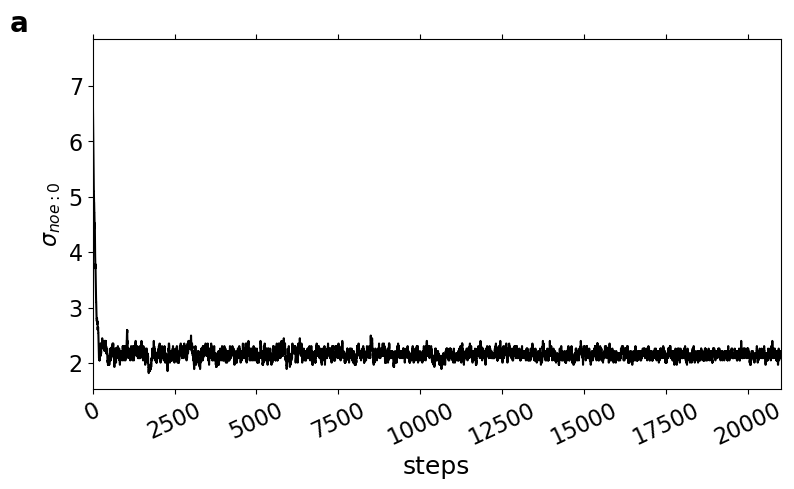

In [11]:
C.plot_traces(figname="test.pdf", xlim=(0, traj["trajectory"][-1][0]), figsize=figsize)

In [12]:
A = biceps.Analysis(sampler, outdir=outdir, nstates=len(energies), MBAR=True, scale_energies=scale_energies)
#A.plot_convergence()
pops = A.P_dP[:,n_lambdas-1]
BS = A.f_df
RMSE = np.sqrt(metrics.mean_squared_error(pops, populations))
print(f"\n\nRMSE = {RMSE}")

 ███████████▍        Time for MBAR: 0.068 s
Writing 5_state/5_state_21_datapoints/Prior_error_0.161/GB_single_sigma/1000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing 5_state/5_state_21_datapoints/Prior_error_0.161/GB_single_sigma/1000_steps_8_replicas_2_lam__swap_every_0/populations.dat...


RMSE = 0.10685069205589671


Top 0 states: [2, 4, 1, 3, 0]
Top 0 populations: [0.01268536 0.03656966 0.25662153 0.30901257 0.38509943]
nplots =  1


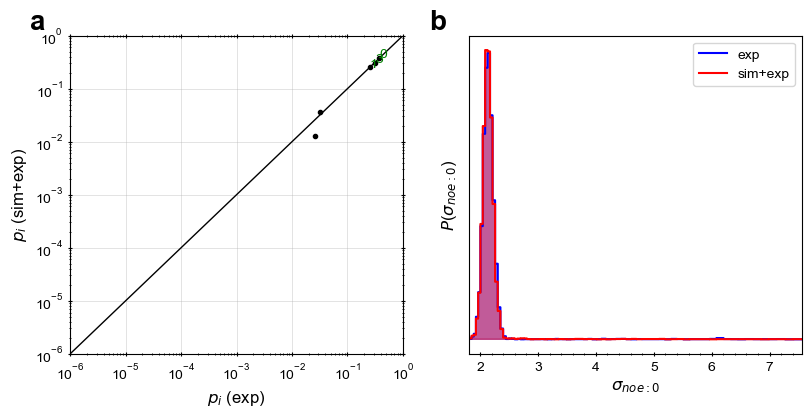

In [13]:
fig = A.plot(plottype)

# Showing that you get a very similar answer when resampling for the total number of steps as we did in chuncks

Time for MBAR: 0.373 s
Writing 5_state/5_state_21_datapoints/Prior_error_0.161/GB_single_sigma/1000_steps_8_replicas_2_lam__swap_every_0/BS.dat...
Writing 5_state/5_state_21_datapoints/Prior_error_0.161/GB_single_sigma/1000_steps_8_replicas_2_lam__swap_every_0/populations.dat...


RMSE = 0.11417551391318437
Top 0 states: [2, 4, 1, 3, 0]
Top 0 populations: [0.00797012 0.02161975 0.25947858 0.32677017 0.38412314]
nplots =  1


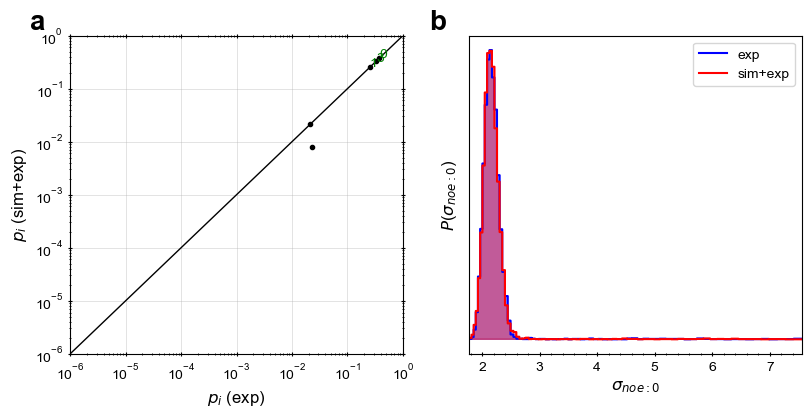

In [14]:
nsteps = traj['trajectory'][-1][0]
ensemble = biceps.ExpandedEnsemble(lambda_values=lambda_values, energies=energies)
ensemble.initialize_restraints(input_data, parameters)
sampler = biceps.PosteriorSampler(ensemble, nreplicas, change_Nr_every,
        write_every=write_every,
        dftilde=dftilde, move_ftilde_every=move_ftilde_every,
        ftilde_sigma=ftilde_sigma, scale_and_offset=scale_and_offset)

sampler.sample(total_nsteps, attempt_lambda_swap_every=swap_every, swap_sigmas=1,
        find_optimal_nreplicas=find_optimal_nreplicas,
        attempt_move_state_every=attempt_move_state_every,
        attempt_move_sigma_every=attempt_move_sigma_every,
        burn=burn, print_freq=1, walk_in_all_dim=walk_in_all_dim,
        verbose=0, progress=1, multiprocess=multiprocess, capture_stdout=1)
A = biceps.Analysis(sampler, outdir=outdir, nstates=len(energies), MBAR=True, scale_energies=scale_energies)
#A.plot_convergence()
pops = A.P_dP[:,n_lambdas-1]
BS = A.f_df
RMSE = np.sqrt(metrics.mean_squared_error(pops, populations))
print(f"\n\nRMSE = {RMSE}")
fig = A.plot(plottype)

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("CSS/notebook_theme.css", "r").read()
    return HTML(styles)
css_styling()